# Homework: Transfer Learning & Domain Adaptation
##  Named Entity Recognition

Today we're gonna solve the problem of named entity recognition. Here's what it does in one picture:
![img](https://commons.bmstu.wiki/images/0/00/NER1.png)
[image source](https://bit.ly/2Pmg7L2)


For each word, in a sentence, model should predict a named entity class: _person, organization, location_ or _miscellaneous_


## Data


### Source domain testset

Our train set consists from texts from different news sources. Therefore as source-domain testset we will use data from [CoNLL-2003 Shared Task](https://github.com/Franck-Dernoncourt/NeuroNER/blob/master/data/conll2003/en). More information about the task can be found [here](https://www.clips.uantwerpen.be/conll2003/ner/).

### Target domain (in-domain) data

As target-domain data we will use data from [WNUT17 Emerging and Rare entity recognition task](http://noisy-text.github.io/2017/emerging-rare-entities.html). This shared task focuses on identifying unusual, previously-unseen entities in the context of emerging discussions. The data were mined from mined from Twitter, Reddit,
YouTube and StackExchange. Results of different competitors of the task were published [here](https://noisy-text.github.io/2017/pdf/WNUT18.pdf).

### Named entity classes

* PER - _person_: names of people (e.g. Alexander S. Pushkin)
* ORG - _organization_: names of corporations (e.g. Yandex), names of non-profit organizations (e.g. UNICEF)
Google).
* LOC - _location_ : e.g. Russia
* MISC - _miscellaneous_ : other named entities including names of products (e.g. iPhone) and creative works (e.g. Bohemian Rhapsody)

### Evaluation metrics

As evaluation metrics we will F1 measure on exact matched NEs. It means that partially overlapped enitities of same class are considered as mismatch.
For example, LOC entities below is partially overlapped. And it is a mismatch:

__O, B-LOC, I-LOC, O__

__O, B-LOC, I-LOC, I-LOC__

Details can be found in the code of _conlleval.py_

### Data format

The format of all dataset follows popular [IOB format](https://en.wikipedia.org/wiki/Inside–outside–beginning_(tagging)). The B- prefix before a tag indicates that the tag is the beginning of a chunk, and an I- prefix before a tag indicates that the tag is inside a chunk. The B- tag is used only when a tag is followed by a tag of the same type without O tokens between them. An O tag indicates that a token belongs to no chunk.

The named entity labels include:
* __B-LOC__ - location - first token
* __I-LOC__ - location - subsequent tokens
* __B-ORG__ - organization - first token
* __O__ - not a named entity

### Part 1: dataset exploration

To load datasets we will use `huggingface/datasets` library:

https://huggingface.co/docs/datasets/

In [ ]:
!pip3 install datasets

In [2]:
import datasets
import typing as tp

In [ ]:
conll = datasets.load_dataset("conll2003")
wnut = datasets.load_dataset("wnut_17")

In [4]:
conll_test = conll["test"]
conll_train = conll["train"]

wnut_test = wnut["train"]
wnut_train = wnut["test"]

This datasets is a actually `DatasetDict`s.

To see class hierarchy we can use `getmro` function from `inspect` library.

In [5]:
import inspect
inspect.getmro(type(conll))

(datasets.dataset_dict.DatasetDict, dict, object)

In [6]:
print(conll.keys(), wnut.keys())

dict_keys(['train', 'validation', 'test']) dict_keys(['train', 'validation', 'test'])


Let's have a look at content of test part CONLL dataset:

In [7]:
conll["test"].features

{'chunk_tags': Sequence(feature=ClassLabel(num_classes=23, names=['O', 'B-ADJP', 'I-ADJP', 'B-ADVP', 'I-ADVP', 'B-CONJP', 'I-CONJP', 'B-INTJ', 'I-INTJ', 'B-LST', 'I-LST', 'B-NP', 'I-NP', 'B-PP', 'I-PP', 'B-PRT', 'I-PRT', 'B-SBAR', 'I-SBAR', 'B-UCP', 'I-UCP', 'B-VP', 'I-VP'], id=None), length=-1, id=None),
 'id': Value(dtype='string', id=None),
 'ner_tags': Sequence(feature=ClassLabel(num_classes=9, names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC'], id=None), length=-1, id=None),
 'pos_tags': Sequence(feature=ClassLabel(num_classes=47, names=['"', "''", '#', '$', '(', ')', ',', '.', ':', '``', 'CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS', 'LS', 'MD', 'NN', 'NNP', 'NNPS', 'NNS', 'NN|SYM', 'PDT', 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'SYM', 'TO', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB'], id=None), length=-1, id=None),
 'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)}

In [8]:
conll["test"].dataset_size, len(conll["test"])

(10252791, 3454)

Let's have a look at single example in the dataset:

In [9]:
conll["test"][50]

{'chunk_tags': [11, 13, 11, 12, 12],
 'id': '50',
 'ner_tags': [0, 0, 0, 7, 8],
 'pos_tags': [24, 15, 12, 22, 22],
 'tokens': ['Results', 'of', 'the', 'World', 'Cup']}

There is a fancy visualizer in `spacy` nlp library we can adapt for custom dataset.

In [10]:
from spacy import displacy

In [12]:
def get_ner_index(index, names):
    return globals()[names].features["ner_tags"].feature.names[index]

def ner_render(dicts: str, tokens: tp.Sequence[str], ner_tags: tp.Sequence[str], title: tp.Optional[str] = None, **kwargs):
    pos = 0
    ents = []
    for word, tag in zip(tokens, ner_tags):
        tag = get_ner_index(tag, dicts)
        if tag.startswith('B'):
            ents.append({
                "start": pos,
                "end": pos + len(word),
                "label": tag.split("-")[1]
            })
        elif tag.startswith('I'):
            ents[-1]["end"] = pos + len(word)
        pos += (len(word) + 1)
    displacy.render({
        "text": " ".join(tokens),
        "ents": ents,
        "title": title
    }, style="ent", manual=True, jupyter=True)

Voilà!

In [13]:
ner_render('conll_train', **conll_test[50])
ner_render('conll_train', **conll_test[200])

Let's compare CONLL and WNUT named entity tags. We need to count each type of tags in both datasets

In [14]:
from itertools import chain
from collections import Counter

conll_tag_counts = Counter()
wnut_tag_counts = Counter()

for tags in conll_test["ner_tags"]:
  conll_tag_counts.update(tags)

for tags in wnut_test["ner_tags"]:
  wnut_tag_counts.update(tags)

In [15]:
wnut_tag_counts

Counter({0: 59570,
         1: 221,
         2: 46,
         3: 140,
         4: 206,
         5: 264,
         6: 150,
         7: 548,
         8: 245,
         9: 660,
         10: 335,
         11: 142,
         12: 203})

In [16]:
conll_tag_counts

Counter({0: 38323,
         1: 1617,
         2: 1156,
         3: 1661,
         4: 835,
         5: 1668,
         6: 257,
         7: 702,
         8: 216})

Thus, WNUT and CONLL have different set of NE tags (labels).

From WNUT description:

**person** –  Names  of  people  (e.g.Virginia Wade).   Don’t mark people that don’t have their own name.  Include punctuation in the middle ofnames.  Fictional people can be included, as long as they’re referred to by name (e.g.Harry Potter).

**location** –  Names  that  are  locations  (e.g. France).    Don’t  mark  locations  that  don’t  have their own name.  Include punctuation in the middle of names. Fictional locations can be included, as long as they’re referred to by name (e.g.Hogwarts)

**corporation** –  Names  of  corporations  (e.g.Google).   Don’t  mark  locations  that  don’t  have their own name. Include punctuation in the middle of names

**product** –  Name  of  products  (e.g. iPhone). Don’t  mark  products  that  don’t  have  their  own name. Include punctuation in the middle of names. Fictional  products  can  be  included,  as  long  as they’re referred to by name (e.g.Everlasting Gobstopper).  It’s got to be something you can touch, and it’s got to be the official name.

**creative-work** –  Names  of  creative  works (e.g.Bohemian Rhapsody). Include punctuation inthe middle of names. The work should be created by a human, and referred to by its specific name.

**group** – Names of groups (e.g.Nirvana, SanDiego  Padres). Don’t  mark  groups  that  don’t have a specific, unique name, or companies (which should be marked corporation).


We can match CONLL and WNUT labels using next rules:

In [17]:
conll_test.features["ner_tags"].feature.names

['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC']

In [18]:
wnut_test.features["ner_tags"].feature.names

['O',
 'B-corporation',
 'I-corporation',
 'B-creative-work',
 'I-creative-work',
 'B-group',
 'I-group',
 'B-location',
 'I-location',
 'B-person',
 'I-person',
 'B-product',
 'I-product']

In [19]:
label_mapping = {
    0: 0, # 'O': 'O',
    7: 5, # 'B-location': 'B-LOC',
    8: 6, # 'I-location': 'I-LOC',
    5: 3, # 'B-group': 'B-ORG',
    1: 3, # 'B-corporation': 'B-ORG',
    9: 1, # 'B-person': 'B-PER',
    3: 7, # 'B-creative-work': 'B-MISC',
    11: 7, # 'B-product': 'B-MISC',
    10: 2, # 'I-person': 'I-PER',
    4: 8, # 'I-creative-work': 'I-MISC',
    2: 4, # 'I-corporation': 'I-ORG',
    6: 4, # 'I-group': 'I-ORG',
    12: 8 # 'I-product': 'I-MISC'
}

In [20]:
def convert_label_sequence(example: tp.Dict[str, tp.Any], label_mapping: tp.Dict[str, str]) -> tp.Dict[str, tp.Any]:
    converted_example = dict(**example)
    converted_example["ner_tags"] = [label_mapping[label] for label in example["ner_tags"]]
    return converted_example

In [ ]:
converted_wnut = wnut.map(lambda x: convert_label_sequence(x, label_mapping))

In [22]:
converted_wnut_train = converted_wnut["train"]
converted_wnut_test = converted_wnut["test"]

In [25]:
converted_wnut["train"].features["ner_tags"].feature.names = conll_train.features["ner_tags"].feature.names
converted_wnut["test"].features["ner_tags"].feature.names = conll_test.features["ner_tags"].feature.names

converted_wnut["train"].features["ner_tags"].feature.num_classes = conll_train.features["ner_tags"].feature.num_classes
converted_wnut["test"].features["ner_tags"].feature.num_classes = conll_test.features["ner_tags"].feature.num_classes

**Before:**

In [26]:
ner_render("wnut_train", **wnut["train"][0])
ner_render("wnut_train", **wnut["train"][1])
ner_render("wnut_train", **wnut["train"][2])

**After label mapping:**

In [27]:
ner_render("converted_wnut_train", **converted_wnut["train"][0])
ner_render("converted_wnut_train", **converted_wnut["train"][1])
ner_render("converted_wnut_train", **converted_wnut["train"][2])

To visualize lexical differences between WNUT and CONLL let's use `scattertext` library.

In [28]:
from IPython.display import IFrame
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))
import matplotlib.pyplot as plt
from IPython.display import IFrame
%matplotlib inline 

In [ ]:
!pip3 install scattertext

In [ ]:
import scattertext as st
import pandas as pd

In [ ]:
conll_df = pd.DataFrame([{"text": " ".join(example["tokens"]), "ner_tags": example["ner_tags"], "dataset": "conll"} for example in conll["train"]])
wnut_df = pd.DataFrame([{"text": " ".join(example["tokens"]), "ner_tags": example["ner_tags"], "dataset": "wnut"} for example in converted_wnut["train"]])

In [ ]:
df = pd.concat([conll_df, wnut_df]).assign(
    parse=lambda df: df.text.apply(st.whitespace_nlp_with_sentences)
)

corpus = st.CorpusFromParsedDocuments(
    df, category_col='dataset', parsed_col='parse'
).build().get_unigram_corpus().compact(st.AssociationCompactor(2000))

In [ ]:
html = st.produce_scattertext_explorer(
    corpus,
    category='conll', category_name='CONLL', not_category_name='WNUT',
    minimum_term_frequency=0, pmi_threshold_coefficient=0,
    width_in_pixels=1000,
    transform=st.Scalers.dense_rank
)

with open("difference.html", "w") as outf:
    print(html, file=outf)

In [ ]:
IFrame("difference.html", width=1200, height=1000)

### Part 2: BERT sequence labeling recap (2 points)

https://huggingface.co/transformers/task_summary.html#named-entity-recognition

The sequence labeling task is a degenerate case of the seq2seq task: we need to map a sequence of words to a sequence of labels (tags) of **the same length**.

In case of BERT we want to get a vector of probabilities of labels for each input token. The simplest way to make it is just feed output token embeddings to Linear layer.

`transformers` class `BertForTokenClassification` works just like this.

![image.png](attachment:image.png)

Image from FastAI article: https://d2l.ai/chapter_natural-language-processing-applications/finetuning-bert.html

#### 2.1 Load pre-trained BERT-based sequence tagger

In [ ]:
!pip3 install transformers

In [97]:
from transformers import pipeline, AutoModelForTokenClassification, AutoTokenizer

name = "dslim/bert-base-NER"
tokenizer = AutoTokenizer.from_pretrained(name)
model = AutoModelForTokenClassification.from_pretrained(name)

Let's have a look at `BertForTokenClassification` class hierarchy

In [31]:
inspect.getmro(type(model))

(transformers.models.bert.modeling_bert.BertForTokenClassification,
 transformers.models.bert.modeling_bert.BertPreTrainedModel,
 transformers.modeling_utils.PreTrainedModel,
 torch.nn.modules.module.Module,
 transformers.modeling_utils.ModuleUtilsMixin,
 transformers.generation_utils.GenerationMixin,
 transformers.utils.hub.PushToHubMixin,
 object)

In `transformers.BertPreTrainedModel` there is an important attribute `config`. Let's have a look. 

In [32]:
model.config

BertConfig {
  "_name_or_path": "dslim/bert-base-NER",
  "_num_labels": 9,
  "architectures": [
    "BertForTokenClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "O",
    "1": "B-MISC",
    "2": "I-MISC",
    "3": "B-PER",
    "4": "I-PER",
    "5": "B-ORG",
    "6": "I-ORG",
    "7": "B-LOC",
    "8": "I-LOC"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "B-LOC": 7,
    "B-MISC": 1,
    "B-ORG": 5,
    "B-PER": 3,
    "I-LOC": 8,
    "I-MISC": 2,
    "I-ORG": 6,
    "I-PER": 4,
    "O": 0
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.18.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size"

As mentioned above `BertForTokenClassification` = BERT + linear classifier

In [33]:
model.classifier

Linear(in_features=768, out_features=9, bias=True)

We need to change order of `ner_tags`, because in ConLL dataset there are another.

In [35]:
model.config.id2label = {key: value for key, value in enumerate(conll["test"].features["ner_tags"].feature.names)}
model.config.label2id = {value: key for key, value in enumerate(conll["test"].features["ner_tags"].feature.names)}

Let's explore one example from dataset:

In [36]:
ner_render('conll_test', **conll["test"][10])

Tokenizer call splits sequence of words to sequnce of word pieces (bpe units) and maps it to token ids.

In [37]:
encoded = tokenizer(conll["test"][10]["tokens"], is_split_into_words=True)

In [38]:
encoded

{'input_ids': [101, 22515, 4786, 2315, 22515, 1968, 5389, 2297, 1103, 2981, 1107, 1103, 5385, 1582, 2517, 117, 4703, 1106, 1246, 170, 8790, 5864, 3031, 2176, 14932, 27547, 12610, 2771, 2019, 1103, 8697, 2273, 1134, 10159, 10293, 27400, 1813, 1691, 1106, 1138, 2262, 1133, 1173, 2148, 1106, 7324, 1154, 1103, 5795, 119, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

Here:

`input_ids` - indices of input sequence tokens in the vocabulary

`token_type_ids` - segment token indices to indicate first and second portions of the inputs. Indices are selected in [0, 1]: 0 corresponds to a sentence A token, 1 corresponds to a sentence B token

`attention_mask` - mask to avoid performing attention on padding token indices. Mask values selected in [0, 1]:

As we discussed above in sequence labeling task output sequence length should be equal to input sequence length.

Tokenizer can split single world to multiple pieces:

In [39]:
print(f"Original sentence:\n---\n{' '.join(conll['test'][10]['tokens'])}")

tokenized = " ".join([tokenizer.convert_ids_to_tokens(id_) for id_ in encoded["input_ids"]])
print(f"\nTokenized sentence:\n---\n{tokenized}")

Original sentence:
---
Takuya Takagi scored the winner in the 88th minute , rising to head a Hiroshige Yanagimoto cross towards the Syrian goal which goalkeeper Salem Bitar appeared to have covered but then allowed to slip into the net .

Tokenized sentence:
---
[CLS] Ta ##ku ##ya Ta ##ka ##gi scored the winner in the 88 ##th minute , rising to head a Hi ##ros ##hi ##ge Yan ##agi ##moto cross towards the Syrian goal which goalkeeper Salem Bit ##ar appeared to have covered but then allowed to slip into the net . [SEP]


For example named entity `Takuya Takagi` transforms into `Ta ##ku ##ya Ta ##ka ##gi`. We need to preserve invariant: input sequence length = output sequence length. So sequence labels (tags) should be tokenized too.


```
Takuya Takagi -> Ta    ##ku   ##ya   Ta     ##ka    ##gi
   |     |        |     |       |     |      |        |
B-PER  I-PER    B-PER  I-PER  I-PER  I-PER  I-PER   I-PER 
```

Let's write function for it.

In [40]:
import transformers
import torch

In [44]:
def tokenize_and_preserve_tags(example: tp.Dict[str, tp.Any],
                               model,
                               tokenizer: transformers.BertTokenizer,
                               label2id: tp.Dict[str, int],
                               tokenizer_params={}) -> tp.Dict[str, tp.Any]:
    # function to split each pair of word-token to same number of pieces.
    encoded = tokenizer(example["tokens"], is_split_into_words=True, **tokenizer_params)
    encoded.update(example)

    word_ids = encoded.word_ids()
    text_labels = []
    for i in range(1, len(word_ids) - 1):
        label = example["ner_tags"][word_ids[i]]
        if isinstance(label, int):
            label = model.config.id2label[label]
        if label == "O" or word_ids[i - 1] != word_ids[i]:
            text_labels.append(label)
        else:
            text_labels.append("I" + label[1:])
    text_labels = ["O"] + text_labels + ["O"]

    for key in ['input_ids', 'attention_mask', 'token_type_ids']:
        encoded[key] = torch.tensor(encoded[key])

    encoded['labels'] = [label2id[label] for label in text_labels]
    encoded['text_labels'] = text_labels
    
    assert len(encoded['labels']) == len(encoded["input_ids"])
    return encoded

In [45]:
test_sentence = "His name is Jerry Abrahamson"
test_example = {"tokens": test_sentence.split(" "), "ner_tags": ["O", "O", "O", "B-PER", "I-PER"]}
test_result = tokenize_and_preserve_tags(test_example, model, tokenizer, model.config.label2id)

assert tokenizer.decode(test_result['input_ids']) == '[CLS] His name is Jerry Abrahamson [SEP]'

                                     #CLS     His  name is    Jerry    Abraham   ##son      SEP
assert test_result['text_labels'] == ["O"] + ["O", "O", "O", "B-PER", "I-PER",  "I-PER"] + ["O"]

In [ ]:
conll = conll.map(lambda x: tokenize_and_preserve_tags(x, model, tokenizer, model.config.label2id))

In [ ]:
wnut = converted_wnut
wnut = wnut.map(lambda x: tokenize_and_preserve_tags(x, model, tokenizer, model.config.label2id))

Next step is convert all numpy.arrays to torch.tensors:

In [117]:
conll.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'labels'], output_all_columns=True)
wnut.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'labels'], output_all_columns=True)

In [119]:
conll["test"][2]

{'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 'chunk_tags': [11, 0, 11, 12, 12, 12],
 'id': '2',
 'input_ids': tensor([  101, 18589,   118, 19016,  2249,   117,  1244,  4699, 14832,  1820,
           118,  1367,   118,  5037,   102]),
 'labels': tensor([0, 5, 6, 6, 6, 0, 5, 6, 6, 0, 0, 0, 0, 0, 0]),
 'ner_tags': [5, 0, 5, 6, 6, 0],
 'pos_tags': [22, 6, 22, 22, 23, 11],
 'text_labels': ['O',
  'B-LOC',
  'I-LOC',
  'I-LOC',
  'I-LOC',
  'O',
  'B-LOC',
  'I-LOC',
  'I-LOC',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O'],
 'token_type_ids': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'tokens': ['AL-AIN', ',', 'United', 'Arab', 'Emirates', '1996-12-06']}

To use `transformers.Dataset` with `torch.DataLoader` we need a custom function to pad sequences and make batches.

In [51]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
model.to(device)

In [120]:
from collections import defaultdict
class PadSequence:
    def __init__(self, padded_columns, device='cuda'):
        self.padded_columns = set(padded_columns)
        self.device = device

    def __call__(self, batch):
        padded_batch = defaultdict(list)
        for example in batch:
            for key, tensor in example.items():
                padded_batch[key].append(tensor)
                
        for key, val in padded_batch.items():
            if key in self.padded_columns:
                padded_batch[key] = torch.nn.utils.rnn.pad_sequence(val, batch_first=True).to(self.device)
        return padded_batch

In [121]:
conll_test_dataloader = torch.utils.data.DataLoader(conll["test"], batch_size=4, collate_fn=PadSequence(['input_ids', 'token_type_ids', 'attention_mask', 'labels']))

Let's test it:

In [122]:
test_batch = next(iter(conll_test_dataloader))
model_output = model(input_ids=test_batch["input_ids"],
                     token_type_ids=test_batch["token_type_ids"],
                     attention_mask=test_batch["attention_mask"],
                     labels=test_batch["labels"], return_dict=True)

Model output contains only `loss` and `logits`. We need to write simple wrapper to convert raw logits to token sequence.

In [108]:
class NamedEntityPredictor:
    def __init__(self,
                 model: transformers.BertForTokenClassification,
                 tokenizer: transformers.BertTokenizer,
                 id2label: tp.Optional[tp.Dict[str, int]] = None):
        self.model = model
        self.tokenizer = tokenizer
        self.id2label = model.config.id2label if id2label is None else id2label
    
    def predict(self, batch: tp.Dict[str, tp.Any]):
        self.model.eval()
        with torch.no_grad():
            model_output = self.model(input_ids=batch["input_ids"],
                                      token_type_ids=batch["token_type_ids"],
                                      attention_mask=batch["attention_mask"],
                                      labels=batch["labels"],
                                      return_dict=True)
        indices = torch.argmax(model_output.logits, axis=2)
        indices = indices.detach().cpu().numpy()

        attention_mask = batch["attention_mask"].cpu().numpy()
        batch_size = len(batch["input_ids"])
        predicted_labels = []
        for i in range(batch_size):
            predicted_labels.append([self.id2label[id_] for id_ in indices[i][attention_mask[i] == 1]])
            
        return {
            "predicted_labels": predicted_labels,
            "loss": model_output.loss,
            "logits": model_output.logits
        }

In [123]:
ner = NamedEntityPredictor(model, tokenizer)
test_prediction = ner.predict(test_batch)
assert test_prediction['predicted_labels'][2] == list(test_batch["text_labels"][2])

In [131]:
import tqdm

Let's measure quality of NER for in-domain and out-domain testset.

To compare models we can use F1 measure. There is a great package `seqeval` to make such quality measurements.

In [ ]:
!pip3 install seqeval

In [133]:
conll_test_dataloader = torch.utils.data.DataLoader(conll["test"], batch_size=16, collate_fn=PadSequence(['input_ids', 'token_type_ids', 'attention_mask', 'labels']))
wnut_test_dataloader = torch.utils.data.DataLoader(wnut["test"], batch_size=16, collate_fn=PadSequence(['input_ids', 'token_type_ids', 'attention_mask', 'labels']))

In [ ]:
ner = NamedEntityPredictor(model, tokenizer)
predicted_labels = {"wnut_test": [], "conll_test": []}

for batch in tqdm.tqdm_notebook(conll_test_dataloader):
    predicted_labels["conll_test"].extend(ner.predict(batch)["predicted_labels"])
    
for batch in tqdm.tqdm_notebook(wnut_test_dataloader):
    predicted_labels["wnut_test"].extend(ner.predict(batch)["predicted_labels"])

In [135]:
import seqeval

In [136]:
from seqeval.metrics import classification_report

In [137]:
conll_report = classification_report(y_true=[list(example["text_labels"]) for example in conll["test"]],
                                                     y_pred=predicted_labels["conll_test"])

In [138]:
wnut_report = classification_report(y_true=[list(example["text_labels"]) for example in wnut["test"]],
                                                    y_pred=predicted_labels["wnut_test"])

In [139]:
print(f"CONLL:\n {conll_report}")
print(f"WNUT:\n {wnut_report}")

CONLL:
               precision    recall  f1-score   support

         LOC       0.75      0.84      0.79      1668
        MISC       0.58      0.70      0.63       702
         ORG       0.71      0.82      0.76      1661
         PER       0.36      0.58      0.45      1617

   micro avg       0.58      0.74      0.65      5648
   macro avg       0.60      0.74      0.66      5648
weighted avg       0.61      0.74      0.66      5648

WNUT:
               precision    recall  f1-score   support

         LOC       0.45      0.51      0.48       150
        MISC       0.17      0.22      0.19       269
         ORG       0.16      0.30      0.21       231
         PER       0.30      0.30      0.30       429

   micro avg       0.24      0.31      0.27      1079
   macro avg       0.27      0.33      0.29      1079
weighted avg       0.26      0.31      0.28      1079



As we can see WNUT model perfomance is poor. Let's test hypothesis that for CONLL-like inputs NER quality will be higher.

To make this we will train a simple log-regression to classify sentences between two datasets based on their sentence embeddings.

The sentence embeddings can be obtained from [CLS] token embedding.

For classification we will train vanilla sklearn log-regression. Just like on picture below, but we will use ordinary BERT for sentence embeddings.

![image.png](attachment:image.png)

Picture from great [Jay Alammar's blog post](http://jalammar.github.io/a-visual-guide-to-using-bert-for-the-first-time/)

In [ ]:
!pip3 install nltk

In [141]:
def get_sentence_embeddings(model, batch):
    model.eval()
    with torch.no_grad():
        return model.bert(input_ids=batch["input_ids"],
                          token_type_ids=batch["token_type_ids"],
                          attention_mask=batch["attention_mask"],
                          return_dict=True)["last_hidden_state"].cpu().numpy()[:,0]

In [ ]:
X = []
Y = []

conll_train_dataloader = torch.utils.data.DataLoader(conll["train"], batch_size=32, collate_fn=PadSequence(['input_ids', 'token_type_ids', 'attention_mask', 'labels']))
wnut_train_dataloader = torch.utils.data.DataLoader(wnut["train"], batch_size=32, collate_fn=PadSequence(['input_ids', 'token_type_ids', 'attention_mask', 'labels']))

for batch in tqdm.tqdm_notebook(conll_train_dataloader):
    X.append(get_sentence_embeddings(model, batch))
    Y.extend([0] * len(batch["input_ids"]))
    
for batch in tqdm.tqdm_notebook(wnut_train_dataloader):
    X.append(get_sentence_embeddings(model, batch))
    Y.extend([1] * len(batch["input_ids"]))

In [144]:
import numpy as np

In [145]:
X = np.concatenate(X)
Y = np.array(Y)

In [151]:
from sklearn.linear_model import LogisticRegression

In [ ]:
dataset_classifier = LogisticRegression(max_iter=1000)
dataset_classifier.fit(X, Y)

In [ ]:
wnut_test_scores = []

wnut_test_dataloader = torch.utils.data.DataLoader(wnut["test"], batch_size=32, collate_fn=PadSequence(['input_ids', 'token_type_ids', 'attention_mask', 'labels']))
for batch in tqdm.tqdm_notebook(wnut_test_dataloader):
    x = get_sentence_embeddings(model, batch)
    wnut_test_scores.append(dataset_classifier.predict_proba(x)[:,1])
    

In [154]:
wnut_test_scores = np.concatenate(wnut_test_scores)

In [ ]:
import matplotlib.pyplot as plt
%pylab inline

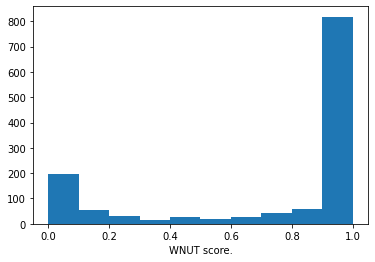

In [156]:
plt.hist(wnut_test_scores)
plt.xlabel("WNUT score.")
plt.show()

In [157]:
score_indices = np.argsort(wnut_test_scores)

In [ ]:
wnut_predicted_labels = np.array(predicted_labels["wnut_test"])[np.argsort(wnut_test_scores)]

In [ ]:
wnut_true_labels = np.array([list(example["text_labels"]) for example in wnut["test"]])[np.argsort(wnut_test_scores)]

After sorting true and predicted labels based on WNUT score let split them into 5 chunks and measure F1. 

In [160]:
predicted_splits = np.array_split(wnut_predicted_labels, 5, )
true_splits = np.array_split(wnut_true_labels, 5)
score_splits = np.array_split(wnut_test_scores[np.argsort(wnut_test_scores)], 5)

In [161]:
print("score\tf1")
for scores, true_split, predicted_split in zip(score_splits, true_splits, predicted_splits):
    mean_score = np.mean(scores)
    f1 = seqeval.metrics.f1_score(true_split, predicted_split)
    print(f"{mean_score:.3f}\t{f1:.3f}")

score	f1
0.055	0.453
0.688	0.319
0.985	0.308
0.999	0.177
1.000	0.152


So:

**The bigger domain shift the lower f1 measure**